In [21]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Load Datasets

In [22]:
# load datasets
ds_berekely_hate = load_dataset("ucberkeley-dlab/measuring-hate-speech")
ds_mlma_hate = load_dataset("nedjmaou/MLMA_hate_speech")

train_berekely_hate = ds_berekely_hate["train"]
train_mlma_hate = ds_mlma_hate["train"]

print(train_berekely_hate)
print(train_mlma_hate)

Dataset({
    features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target_gender_non_binary', 'target_

In [23]:
# FILTER NON-HATE SAMPLES
train_berkeley_hate_non_hate = train_berekely_hate.filter(
    lambda x: x["sentiment"] == 0 
       and x["hatespeech"] == 0 
       and x["hate_speech_score"] < 0
    )

print(f"Number of non-hate samples in Berkeley datset: {len(train_berkeley_hate_non_hate)}")
# print(train_berkeley_hate_non_hate["text"])

Number of non-hate samples in Berkeley datset: 9520


In [24]:
# Convert MLMA and Berkeley datasets to pandas DataFrames
mlma_df = train_mlma_hate.to_pandas().reset_index(drop=True)
berkeley_df = train_berkeley_hate_non_hate.to_pandas().reset_index(drop=True)

## Assign Language Column

In [25]:
# Assign language groups by row ranges
berkeley_df['language'] = 'english'

mlma_df['language'] = None
mlma_df.loc[:3352, 'language'] = 'arabic'      # 0 to 3352 (inclusive)
mlma_df.loc[3353:14646, 'language'] = 'english' # 3353 to 14646 (inclusive)
mlma_df.loc[14647:, 'language'] = 'french'      # 14647 to end

# Move 'language' to be the 3rd column
cols = list(mlma_df.columns)
cols.insert(2, cols.pop(cols.index('language')))
mlma_df = mlma_df[cols]

# Check the assignment
print(f"MLMA {mlma_df['language'].value_counts(dropna=False)}\n")
print(f"Berkeley {berkeley_df['language'].value_counts(dropna=False)}")

print(berkeley_df.columns)
print(mlma_df.columns)

MLMA language
english    11294
french      4014
arabic      3353
Name: count, dtype: int64

Berkeley language
english    9520
Name: count, dtype: int64
Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_jewish', 'annotator_religion_mormon',
       'annotator_religion_muslim', 'annotator_religion_nothing',
       'annotator_religion_other', 'annotator_sexuality_bisexual',
       'annotator_sexuality_gay', 'annotator_sexuality_straight',
       'annotator_sexuality_other', 'language'],
      dtype='object', length=132)
Index(['HITId', 'tweet', 'language', 'sentiment', 'directness',
       'annotator_sentiment', 'target', 'group'],
      dtype='object')


## Clean Columns and Merge

In [26]:
# Defining hate columns
berkeley_df['hatespeech'] = 0
mlma_df['hatespeech'] = 1

# Add an index column to Berkeley dataset called 'HITId' of incrementing ints
berkeley_df['HITId'] = range(len(berkeley_df)) 

# Set MLMA's 'tweet' column to its 'text' column (if not already)
mlma_df.rename(columns={'tweet': 'text'}, inplace=True)

# Set Berkeley's 'sentiment' column to 'normal'
berkeley_df['annotator_sentiment'] = 'normal'
mlma_df.drop(columns=['sentiment'], inplace=True)

# Add new columns to Berkeley with value 'normal'
for col in ['directness', 'annotator_sentiment', 'target', 'group']:
    berkeley_df[col] = 'normal'

# Filter Berkeley dataset for only columns in MLMA
filtered_berkeley_df = berkeley_df[['HITId', 'text', 'language', 'directness', 'annotator_sentiment', 'target', 'group', 'hatespeech']]

# Concatenate the two DataFrames
combined_df = pd.concat([mlma_df, filtered_berkeley_df], ignore_index=True) # ignore_index=True to create new index

print(combined_df.head())
print(combined_df.tail())
print(combined_df.shape)

   HITId                                               text language  \
0      1  صلاة الفجر خير لك من ترديد بول البعير وسبي الن...   arabic   
1      2  صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...   arabic   
2      3  طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...   arabic   
3      4  @user @user انا اوافقك بخصوص السوريين و العراق...   arabic   
4      5  هذه السعودية التي شعبها شعب الخيم و بول البعير...   arabic   

  directness                           annotator_sentiment  target  \
0   indirect                                         shock  gender   
1   indirect  anger_confusion_sadness_indifference_disgust   other   
2   indirect                                  indifference   other   
3     direct                                  indifference  origin   
4   indirect                                  indifference  origin   

        group  hatespeech  
0  individual           1  
1       other           1  
2  individual           1  
3       other           1  
4     

## Encode Categorical Output Variables

In [27]:
label_maps = {}
for col in ['directness', 'target', 'group']:
    le = LabelEncoder()
    combined_df[col + '_label'] = le.fit_transform(combined_df[col].astype(str))
    # Convert keys to str for JSON compatibility
    label_maps[col] = {str(k): v for k, v in zip(le.transform(le.classes_), le.classes_)}

with open('../Data/label_maps.json', 'w') as f:
    json.dump(label_maps, f)

In [28]:
# Split annotator_sentiment values by "_" and count distinct sentiments

# Drop NaN and split by '_', then flatten the list
all_sentiments = combined_df['annotator_sentiment'].apply(lambda x: x.split('_'))
# all_sentiments
flat_sentiments = [sent for sublist in all_sentiments for sent in sublist]
# flat_sentiments 

# Get unique sentiments and their count
unique_sentiments = set(flat_sentiments)
print(f"Distinct annotator sentiments ({len(unique_sentiments)}): {unique_sentiments}")

Distinct annotator sentiments (8): {'disgust', 'shock', 'indifference', 'normal', 'confusion', 'fear', 'anger', 'sadness'}


In [29]:
# Get all unique sentiments
all_sentiments = sorted({s for x in combined_df['annotator_sentiment'].dropna() for s in x.split('_')})

# Multi-hot encode
for sentiment in all_sentiments:
    combined_df[f'sentiment_{sentiment}'] = combined_df['annotator_sentiment'].apply(
        lambda x: int(sentiment in x.split('_')) if isinstance(x, str) else 0
    )
# The columns sentiment_anger, sentiment_confusion, ... are the multi-label targets
print(combined_df.columns)
combined_df.head()

Index(['HITId', 'text', 'language', 'directness', 'annotator_sentiment',
       'target', 'group', 'hatespeech', 'directness_label', 'target_label',
       'group_label', 'sentiment_anger', 'sentiment_confusion',
       'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference',
       'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
      dtype='object')


,HITId,text,language,directness,annotator_sentiment,target,group,hatespeech,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,arabic,indirect,shock,gender,individual,1,1,1,8,0,0,0,0,0,0,0,1
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,arabic,indirect,anger_confusion_sadness_indifference_disgust,other,other,1,1,4,13,1,1,1,0,1,0,1,0
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,arabic,indirect,indifference,other,individual,1,1,4,8,0,0,0,0,1,0,0,0
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,arabic,direct,indifference,origin,other,1,0,3,13,0,0,0,0,1,0,0,0
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,arabic,indirect,indifference,origin,other,1,1,3,13,0,0,0,0,1,0,0,0


## Clean Text

In [30]:
# Clean text for all 3 datasets: combined_df, mlma_df, berkeley_df

def clean_text_column(df, text_col='text', new_col='text_cleaned'):
    unwanted_chars = (
        r'@URL', r'@url', r'@user', r'\\ude02', r'\\ud83d', r'\\u2026', r'\\u201c', r'\\u201d', r'\\udc4d', r'\\n', r'\\uffe3', 
        r'\\ud83e', r'\\udd26', r'\\u2044', r'\\u25d5', r'\\udd26', r'\\u03c9', r'\\ud83c', r'\\udc80', r'\\udded', r'\\uddf7', 
        r'\\u2022', r'\\u25e1', r'\\udffd', r'\\u200d', r'\\u2640', r'\\ude37', r'\\udc40', r'\\ude1f', r'\\udd37', r'\\u2642', 
        r'\\ude2d', r'\\udd25', r'\\ude44', r'\\u2018', r'\\u2744', r'\\udff3', r'\\udf08', r'\\udc13', r'\\udd38', r'\\udc4a', 
        r'\\ude12', r'\\uddfa', r'\\uddf2', r'\\uded1', r'\\u25b7', r'\\u25c1', r'\\u2665', r'\\uff46', r'\\uff41', r'\\uff45', 
        r'\\uff54', r'\\udc47', r'\\udffb', r'\\ude05', r'\\udc4c', r'\\u270b', r'\\udeab', r'\\udfe2', r'\\uddf9', r'\\ude08', 
        r'\\udc3e', r'\\ude03', r'\\udca3', r'\\ude0e', r'\\udd23', r'\\udd95', r'\\udf33', r'\\ude1a', r'\\udf8a', r'\\udd2a',
        r'\\u2800', r'\\u275b', r'&amp', r'&gt;', r'&lt;', r'URL'
    )
    df[new_col] = df[text_col].copy()
    df[new_col] = df[new_col].str.replace(r'\\u2019', "'", case=False, regex=True)
    for char in unwanted_chars:
        df[new_col] = df[new_col].str.replace(char, " ", case=False, regex=True)
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'\s+', ' ', x.strip()) if isinstance(x, str) else x)
    return df

combined_df = clean_text_column(combined_df)
mlma_df = clean_text_column(mlma_df)
berkeley_df = clean_text_column(berkeley_df)

## Visualizations

### Text Length Distributions

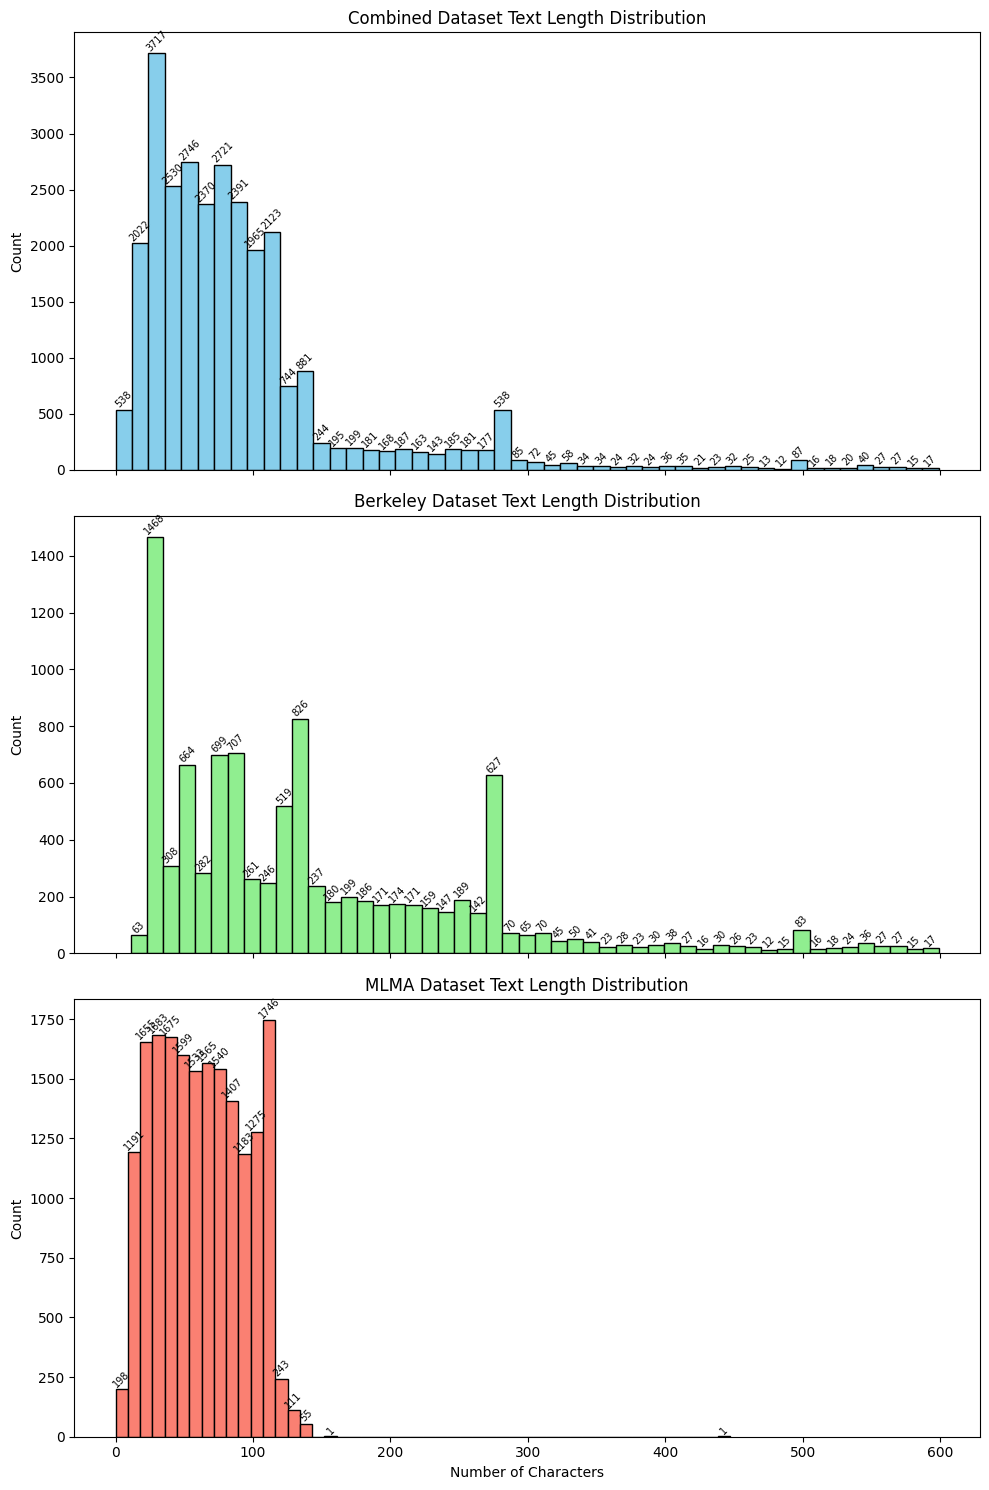

In [31]:
datasets = [
    ("Combined Dataset", combined_df),
    ("Berkeley Dataset", berkeley_df),
    ("MLMA Dataset", mlma_df)
]

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for ax, (title, df), color in zip(axes, datasets, ['skyblue', 'lightgreen', 'salmon']):
    df['text_length'] = df['text_cleaned'].astype(str).apply(len)
    counts, bins, patches = ax.hist(df['text_length'], bins=50, color=color, edgecolor='black')
    ax.set_title(f"{title} Text Length Distribution")
    ax.set_ylabel('Count')
    for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
        if count > 0:
            ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                    ha='center', va='bottom', fontsize=7, rotation=45)
axes[-1].set_xlabel('Number of Characters')
plt.tight_layout()
plt.show()

In [32]:
# Number English tweets with <= 140 characters in MLMA and Berkeley datasets
print(len(mlma_df[(mlma_df['text_length'] <= 150) & (mlma_df['language'] == 'english')]))
print(len(berkeley_df[(berkeley_df['text_length'] <= 150)]))

11293
6244


### DROP LONGER TEXTS

In [33]:
# So the model does not learn to classify based on text length
print(f"Before filtering out long texts: {combined_df.shape}")
combined_df = combined_df[combined_df['text_length'] <= 150]

print(f"After filtering out long texts: {combined_df.shape}")

Before filtering out long texts: (28181, 21)
After filtering out long texts: (24903, 21)


## Shuffle, Split, and Export Datasets

In [34]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

def iterative_split_and_export(df, prefix):
    # Identify feature and label columns
    label_cols = [col for col in df.columns if col.startswith('sentiment_')]
    feature_cols = [col for col in df.columns if col not in label_cols]
    
    # Convert to numpy arrays
    X = df[feature_cols].values
    y = df[label_cols].values.astype(int)
    
    # First split: train (80%), temp (20%)
    X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.2)
    # Second split: val (10%), test (10%) from temp
    X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)
    
    # Convert back to DataFrames
    train_df = pd.DataFrame(np.hstack([X_train, y_train]), columns=feature_cols + label_cols)
    val_df = pd.DataFrame(np.hstack([X_val, y_val]), columns=feature_cols + label_cols)
    test_df = pd.DataFrame(np.hstack([X_test, y_test]), columns=feature_cols + label_cols)
    
    # Ensure correct dtypes for integer columns
    for col in label_cols + ['directness_label', 'target_label', 'group_label', 'hatespeech']:
        if col in train_df.columns:
            train_df[col] = train_df[col].astype(int)
            val_df[col] = val_df[col].astype(int)
            test_df[col] = test_df[col].astype(int)
    
    # Filter wanted columns
    cols_to_keep = [
        'text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech'
    ] + label_cols
    train_export = train_df[cols_to_keep]
    val_export = val_df[cols_to_keep]
    test_export = test_df[cols_to_keep]
    
    # Output to CSV
    train_export.to_csv(f"../Data/{prefix}_train.csv", index=False)
    val_export.to_csv(f"../Data/{prefix}_val.csv", index=False)
    test_export.to_csv(f"../Data/{prefix}_test.csv", index=False)
    
    print(f"{prefix.capitalize()} Train size: {train_export.shape}")
    print(f"{prefix.capitalize()} Validation size: {val_export.shape}")
    print(f"{prefix.capitalize()} Test size: {test_export.shape}")
    return train_export.head()

# For combined_df
iterative_split_and_export(combined_df, "combined")

# For english_df
english_df = combined_df[combined_df['language'] == 'english'].reset_index(drop=True)
iterative_split_and_export(english_df, "english")

Combined Train size: (19919, 14)
Combined Validation size: (2490, 14)
Combined Test size: (2494, 14)
English Train size: (14093, 14)
English Validation size: (1709, 14)
English Test size: (1735, 14)


,text_cleaned,language,directness_label,target_label,group_label,hatespeech,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,said retard,english,1,0,15,1,0,1,1,0,0,0,0,0
1,u juul ur faggot,english,1,6,13,1,0,1,1,1,1,0,1,0
2,even called country shithole people shithole p...,english,1,3,15,1,1,0,1,1,1,0,1,0
3,canadians never met seen associated person cur...,english,1,0,15,1,0,0,0,0,1,0,1,0
4,south africa years come. keep supporting loud ...,english,1,3,13,1,0,1,0,0,1,0,0,0
